In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import os

In [2]:
os.listdir('/home/sgai/alireza-project/orientation_data/data')

['validation', 'train']

In [6]:
# Configurations
data_dir = '/home/sgai/alireza-project/orientation_data/data'  # Path to the RP2K dataset
batch_size = 32
num_epochs = 30
num_classes = len(os.listdir(os.path.join(data_dir, 'train')))  # Replace with the actual number of classes in RP2K
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
# Data Transformations
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    "validation": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}



In [8]:
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, folders_to_skip=None):
        self.folders_to_skip = folders_to_skip if folders_to_skip else []
        super().__init__(root, transform=transform)

    def make_dataset(
        self, directory, class_to_idx, extensions=None, is_valid_file=None, allow_empty=False
    ):
        if is_valid_file is None and extensions is None:
            raise ValueError("Either 'extensions' or 'is_valid_file' must be provided.")

        # Use extensions as a fallback for file validation if `is_valid_file` is not provided
        def has_file_allowed_extension(filepath, extensions):
            return filepath.lower().endswith(tuple(extensions))

        is_valid_file = is_valid_file or (lambda x: has_file_allowed_extension(x, extensions))

        instances = []
        directory = os.path.expanduser(directory)

        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(directory, target_class)

            if not os.path.isdir(target_dir):
                continue
            if target_class in self.folders_to_skip:
                print(f"Skipping folder: {target_class}")
                continue

            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    if is_valid_file(path):
                        item = (path, class_index)
                        instances.append(item)

        if not instances and not allow_empty:
            raise RuntimeError(f"Found 0 files in {directory}. Supported extensions: {extensions}")
        return instances


In [9]:
folders_to_skip = []

# Create datasets
train_dataset = CustomImageFolder(
    root=os.path.join(data_dir, "train"),
    transform=data_transforms["train"],
    folders_to_skip=folders_to_skip)

val_dataset = CustomImageFolder(
    root=os.path.join(data_dir, "validation"),
    transform=data_transforms["validation"],
    folders_to_skip=folders_to_skip)



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


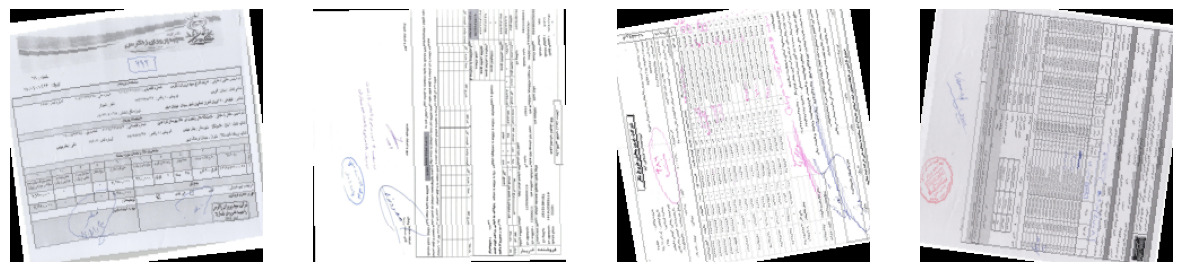

In [28]:
def denormalize(img, mean, std):
    """Denormalize a tensor image for visualization."""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

# Visualize a batch of images
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax = axes[i]
    img = denormalize(images[i], mean, std)  # Denormalize the image
    img = img.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization
    ax.imshow(img.clip(0, 1))  # Clip to valid range [0, 1]
    ax.axis('off')
plt.show()


In [29]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for name, child in model.named_children():
    if name != "layer4":
        for param in child.parameters():
            param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [30]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [param for param in model.parameters() if param.requires_grad],
    lr=1e-4  
)

In [31]:
from tqdm import tqdm  # Import tqdm for progress bars


# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)  


save_dir = "/home/sgai/alireza-project/ResNet18/logs"

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    # Keep track of best validation accuracy
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training Phase
        model.train()
        train_loss, train_correct = 0, 0
        # Wrap train_loader with tqdm for progress bar
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward Pass and Optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Metrics
            train_loss += loss.item() * inputs.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        
        # Validation Phase
        model.eval()
        val_loss, val_correct = 0, 0
        # Wrap val_loader with tqdm for progress bar
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)
        print(f"Learning rate adjusted to: {optimizer.param_groups[0]['lr']:.6f}")

        # Save model after each epoch
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }
        
        # Save regular epoch checkpoint
        torch.save(checkpoint, os.path.join(save_dir,f'epoch_{epoch+1}.pth'))
        print(f"Saved model checkpoint for epoch {epoch+1}")
        
        # Save best model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(checkpoint, os.path.join(save_dir,'best_model.pth'))
            print(f"Saved new best model with validation accuracy: {val_acc:.4f}")
        
        print("-" * 60)


/home/sgai/miniconda3/envs/train_torch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [32]:
num_epochs = 50
train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/50


Train Loss: 0.1412, Train Acc: 0.9590
Val Loss: 0.0063, Val Acc: 1.0000
Learning rate adjusted to: 0.000100
Saved model checkpoint for epoch 1
Saved new best model with validation accuracy: 1.0000
------------------------------------------------------------
Epoch 2/50


Train Loss: 0.0128, Train Acc: 0.9970
Val Loss: 0.0038, Val Acc: 1.0000
Learning rate adjusted to: 0.000100
Saved model checkpoint for epoch 2
------------------------------------------------------------
Epoch 3/50


Train Loss: 0.0083, Train Acc: 0.9985
Val Loss: 0.0017, Val Acc: 1.0000
Learning rate adjusted to: 0.000100
Saved model checkpoint for epoch 3
------------------------------------------------------------
Epoch 4/50


Train Loss: 0.0069, Train Acc: 0.9981
Val Loss: 0.0033, Val Acc: 1.0000
Learning rate adjusted to: 0.000100
Saved model checkpoint for epoch 4
------------------------------------------------------------
Epoch 5/50


Train Loss: 0.0096, Train Acc: 0.9976
Val Loss: 0.0013, Val Acc: 1.0000
Learning rate adjusted to: 0.000100
Saved model checkpoint for epoch 5
------------------------------------------------------------
Epoch 6/50


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/sgai/miniconda3/envs/train_torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3572/3911321770.py", line 2, in <module>
    train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)
  File "/tmp/ipykernel_3572/2237946779.py", line 21, in train_and_validate
    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sgai/miniconda3/envs/train_torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/sgai/miniconda3/envs/train_torch/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
   

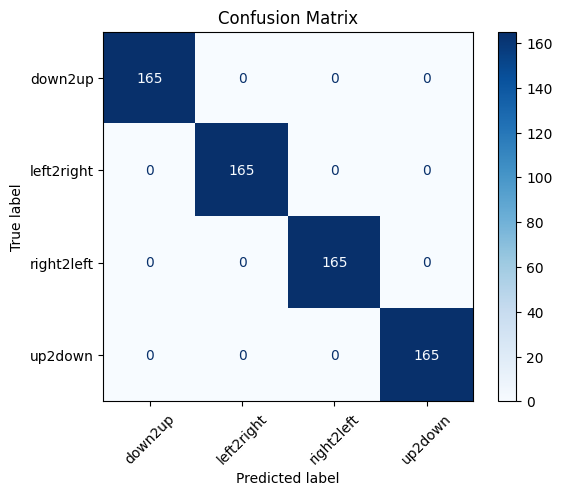

In [10]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to evaluate the model and generate predictions
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get class with highest score
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Generate confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_mapping):
    # Reverse the class_mapping dictionary to get the class names in order
    class_names = [k for k, v in sorted(class_mapping.items(), key=lambda item: item[1])]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


# Evaluate on test data
predictions, true_labels = evaluate_model(model, val_loader, device)

# Class mapping
class_mapping = {'down2up': 0, 'up2down': 3, 'left2right': 1, 'right2left': 2}

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predictions, class_mapping)


In [1]:
pip install scikit-learn==1.2.2


Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms


In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


model.fc = nn.Linear(in_features=512, out_features=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


checkpoint = torch.load('/home/sgai/alireza-project/ResNet18/logs/epoch_4.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Load model state
model.load_state_dict(checkpoint['model_state_dict'])


model.eval()


/tmp/ipykernel_222958/692489396.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/sgai/alireza-project/ResNet18/logs/epoch_4.pth', map_loca

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
pip install scikit-learn

  Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 1.1 MB/s eta 0:00:0000:0100:01
Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.0.2 which is incompatible.
numba 0.59.1 requires numpy<1.27,>=1.22, but you have numpy 2.0.2 which is incompatible.
onnxruntime 1.18.1 requires numpy<2.0,>=1.21.6, but you have numpy 2.0.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sklearn
print(sklearn.__version__)


1.6.0


In [19]:
import torch
from torchvision import transforms
from PIL import Image

# Define preprocessing function
def preprocess_image(image_path, input_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Load and preprocess the image
img = preprocess_image("/home/sgai/alireza-project/document/data/sample-images/data_34.jpg")

# Move image tensor to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img = img.to(device)


# Perform inference
output = model(img)
_, predicted = torch.max(output, 1)

print(f"Predicted class: {predicted.item()}")


Predicted class: 2


In [ ]:
class_mapping = {'down2up': 0, 'up2down': 3, 'left2right': 1, 'right2left': 2}


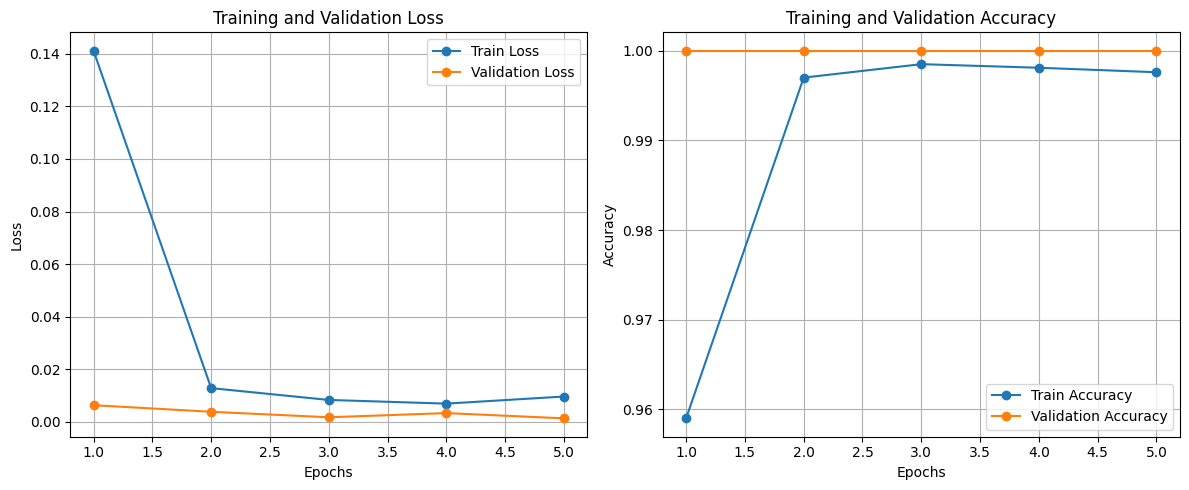

In [1]:
import matplotlib.pyplot as plt

# Data from training logs
epochs = [1, 2, 3, 4, 5]
train_loss = [0.1412, 0.0128, 0.0083, 0.0069, 0.0096]
val_loss = [0.0063, 0.0038, 0.0017, 0.0033, 0.0013]
train_acc = [0.9590, 0.9970, 0.9985, 0.9981, 0.9976]
val_acc = [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

sc_path = '/home/sgai/alireza-project/orientation_data/data/validation/down2up'
tr_path = '/home/sgai/alireza-project/orientation_data/data/train/down2up'

def compare_images(folder1, folder2):
    img_list1 = os.listdir(folder1)
    img_list2 = os.listdir(folder2)
    overlapping_images = []

    for img in img_list1:
        if img in img_list2:
            img1_path = os.path.join(folder1, img)
            img2_path = os.path.join(folder2, img)
            img1 = plt.imread(img1_path)
            img2 = plt.imread(img2_path)

            # Compare pixel-wise equality
            if np.array_equal(img1, img2):
                overlapping_images.append(img)

    # Print the result
    print(f"Overlapping images: {overlapping_images}")

# Run the function
compare_images(sc_path, tr_path)


Overlapping images: []


In [4]:
compare_images(sc_path, tr_path)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/sgai/miniconda3/envs/train_torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_225417/361551877.py", line 1, in <module>
    compare_images(sc_path, tr_path)
  File "/tmp/ipykernel_225417/430719144.py", line 13, in compare_images
    img1 = plt.imread(os.path.join(folder1, img))
  File "/home/sgai/miniconda3/envs/train_torch/lib/python3.9/site-packages/matplotlib/pyplot.py", line 2404, in imread
    return matplotlib.image.imread(fname, format)
  File "/home/sgai/miniconda3/envs/train_torch/lib/python3.9/site-packages/matplotlib/image.py", line 1525, in imread
    with img_open(fname) as image:
  File "/home/sgai/miniconda3/envs/train_torch/lib/python3.9/site-packages/PIL/Image.py", line 3227, in open
    fp = builtins.open(filename, "rb")
IsADirectoryError: [Errno 21] Is a directory: '/home/sgai/alireza-project/orientatio

## Convert 2 ONNX

In [3]:
import torch
import torch.onnx

batch_size = 1  
dummy_input = torch.randn(batch_size, 3, 224, 224, device=device)

# File path to save the ONNX model
onnx_model_path = "/home/sgai/alireza-project/ResNet18/model.onnx"

# Export the model to ONNX format
torch.onnx.export(
    model,                  # PyTorch model
    dummy_input,            # Dummy input tensor
    onnx_model_path,        # Path to save the ONNX model
    export_params=True,     # Store the trained parameter weights
    opset_version=11,       # ONNX opset version to use
    do_constant_folding=True,  # Optimize constant folding
    input_names=['input'],  # Input tensor names
    output_names=['output'],  # Output tensor names
    dynamic_axes={
        'input': {0: 'batch_size'},  # Allow dynamic batch size
        'output': {0: 'batch_size'}
    }
)

print(f"Model exported to {onnx_model_path}")


Model exported to /home/sgai/alireza-project/ResNet18/model.onnx


In [11]:
import onnxruntime as ort
import numpy as np
from torchvision import transforms
from PIL import Image

# Define preprocessing function
def preprocess_image(image_path, input_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor



# Preprocess the image
img = preprocess_image("/home/sgai/alireza-project/5972292144557311481.jpg")

# Convert PyTorch tensor to NumPy array
img_numpy = img.cpu().numpy()

# Load ONNX model
onnx_model_path = "/home/sgai/alireza-project/ResNet18/model.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Run inference
outputs = ort_session.run(None, {'input': img_numpy})

# Process the output
output_tensor = torch.tensor(outputs[0])  # Convert ONNX output to a PyTorch tensor for convenience
_, predicted = torch.max(output_tensor, 1)


class_mapping = {'down2up': 0, 'up2down': 3, 'left2right': 1, 'right2left': 2}
pred2class = {v:k for k,v in class_mapping.items()}


print(f"Predicted class: {pred2class[predicted.item()]}")


Predicted class: down2up


In [40]:
import onnxruntime as ort
import numpy as np
from PIL import Image

def preprocess_image(image_path, input_size=(224, 224)):
    # Open and resize the image
    image = Image.open(image_path).convert("RGB")
    image = image.resize(input_size, Image.Resampling.BICUBIC)

    # Convert the image to a NumPy array and normalize pixel values to [0, 1]
    image_array = np.array(image).astype(np.float32) / 255.0

    # Normalize using the given mean and std for each channel
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    image_array = (image_array - mean) / std

    # Transpose the dimensions to match the input format: (C, H, W)
    image_array = np.transpose(image_array, (2, 0, 1))

    # Add batch dimension: (1, C, H, W)
    image_array = np.expand_dims(image_array, axis=0)

    return image_array


# Preprocess the image


image_path = "/home/sgai/alireza-project/5972292144557311481.jpg"
img = preprocess_image(image_path)

# Ensure the input is float32
img_numpy = img.astype(np.float32)

# Load ONNX model
onnx_model_path = "/home/sgai/alireza-project/ResNet18/model.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Run inference
outputs = ort_session.run(None, {'input': img_numpy})

# Process the output
output_tensor = np.array(outputs[0])  # Convert ONNX output to a NumPy array
predicted_class = np.argmax(output_tensor, axis=1)[0]  # Get the index of the highest probability

# Class mapping
class_mapping = {'down2up': 0, 'up2down': 3, 'left2right': 1, 'right2left': 2}
pred2class = {v: k for k, v in class_mapping.items()}

# Print the predicted class
print(f"Predicted class: {pred2class[predicted_class]}")


Predicted class: down2up


In [41]:
pred2class

{0: 'down2up', 3: 'up2down', 1: 'left2right', 2: 'right2left'}

In [42]:
import cv2
import matplotlib.pyplot as plt 

def get_oriented_image(image, orientation_degree):
    if orientation_degree == 90:
        # Rotate each channel separately
        image = [cv2.flip(channel.T, 0) for channel in cv2.split(image)]
        image = cv2.merge(image)
    elif orientation_degree == 180:
        image = cv2.flip(image, -1)
    elif orientation_degree == 270:
        image = [cv2.flip(channel.T, 1) for channel in cv2.split(image)]
        image = cv2.merge(image)

    return image


def orient_image(image, predictions):
    orient2degree = {'right2left': 270, 'left2right': 90, 'up2down': 180, 'down2up': 0}
    model_label2name = {0: 'down2up', 3: 'up2down', 1: 'left2right', 2: 'right2left'}
    class_name = model_label2name[predictions]
    oriented_image = get_oriented_image(image, orient2degree[class_name])
        
    return oriented_image ,class_name


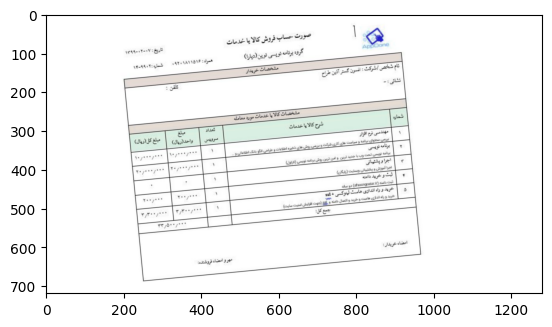

In [43]:
image = cv2.imread(image_path)


oriented_image, pd = orient_image(image,predicted_class)

plt.imshow(oriented_image)